In [277]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [278]:
data = pd.read_csv("dataset.csv")


In [279]:
data

,occupation,age,education_level,marital_status,communication_channel,call_month,call_day,call_duration,call_frequency,previous_campaign_outcome,conversion_status
0,administrative_staff,28,high_school,married,unidentified,September,9,1,1,successful,not_converted
1,administrative_staff,58,unidentified,married,unidentified,June,5,307,2,unidentified,not_converted
2,jobless,40,high_school,divorced,mobile,February,4,113,1,unidentified,not_converted
3,retired_worker,63,high_school,married,mobile,April,7,72,5,unidentified,not_converted
4,business_owner,43,college,married,landline,July,29,184,4,unidentified,not_converted
...,...,...,...,...,...,...,...,...,...,...,...
45206,administrative_staff,50,high_school,divorced,mobile,May,6,114,1,unsuccessful,not_converted
45207,independent_worker,49,college,married,unidentified,May,13,98,1,unidentified,not_converted
45208,executive,30,college,married,mobile,June,12,175,2,other_outcome,not_converted
45209,retired_worker,59,elementary_school,married,landline,July,15,41,5,unidentified,not_converted


In [280]:
# Ensure CUDA availability check is correct
if torch.cuda.is_available():
    device = torch.device('cuda')  # Set device to CUDA
    print("CUDA is available! Using GPU")
else:
    device = torch.device('cpu')  # Fallback to CPU
    print("CUDA not available. Using CPU")

CUDA not available. Using CPU


In [281]:
data_encoded = pd.get_dummies(data, columns=['occupation', 'education_level', 
                                             'marital_status', 'communication_channel', 'previous_campaign_outcome', 'call_month', 'conversion_status'])

data_encoded = data_encoded.astype(int)

In [282]:
X = data_encoded.drop(['conversion_status_converted', 'conversion_status_not_converted'], axis=1)
y = data_encoded['conversion_status_converted']

In [283]:
# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print("Data split into training and testing sets.")
print("Training Set (X_train):", X_train.shape)
print("Training Set (y_train):", y_train.shape)
print("Test Set (X_test):", X_test.shape)
print("Test Set (y_test):", y_test.shape)

Data split into training and testing sets.
Training Set (X_train): (31647, 42)
Training Set (y_train): (31647,)
Test Set (X_test): (13564, 42)
Test Set (y_test): (13564,)


In [284]:
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device).reshape(-1, 1)

In [285]:
X

,age,call_day,call_duration,call_frequency,occupation_administrative_staff,occupation_business_owner,occupation_domestic_worker,occupation_executive,occupation_independent_worker,occupation_jobless,...,call_month_December,call_month_February,call_month_January,call_month_July,call_month_June,call_month_March,call_month_May,call_month_November,call_month_October,call_month_September
0,28,9,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,58,5,307,2,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,40,4,113,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,63,7,72,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,43,29,184,4,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,50,6,114,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
45207,49,13,98,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
45208,30,12,175,2,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
45209,59,15,41,5,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [286]:
# Define the model
model = nn.Sequential(
    nn.Linear(42, 256),
    nn.ReLU(),
    
    nn.Linear(256, 128),
    nn.ReLU(),
    
    nn.Linear(128, 32),
    nn.ReLU(),
    
    nn.Linear(32, 8),
    nn.ReLU(),
    
    nn.Linear(8, 1)
)

print("Model Architecture:")
print(model)

model.to(device)  # Move the model to the specified device

Model Architecture:
Sequential(
  (0): Linear(in_features=42, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=8, bias=True)
  (7): ReLU()
  (8): Linear(in_features=8, out_features=1, bias=True)
)


Sequential(
  (0): Linear(in_features=42, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=8, bias=True)
  (7): ReLU()
  (8): Linear(in_features=8, out_features=1, bias=True)
)

In [287]:
# loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()  # binary cross-entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 100   # number of epochs to run
batch_size = 16  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)


In [288]:
# Hold the best model
best_recall = float('-inf')   # init to negative infinity
best_weights = None
history = []

In [289]:
for epoch in range(n_epochs):
    print(f"\n--- Starting Epoch {epoch} ---")
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            # forward pass
            y_pred_proba = model(X_batch)
            loss = loss_fn(y_pred_proba, y_batch) 
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # update weights
            optimizer.step()
            
            # print progress
            bar.set_postfix(loss=float(loss))
            
    # evaluate accuracy at end of each epoch
    with torch.no_grad():
        y_pred_proba = model(X_test)
        y_pred = (y_pred_proba > 0).float()
        accuracy = accuracy_score(y_test.cpu(), y_pred.cpu())
        precision = precision_score(y_test.cpu(), y_pred.cpu())
        recall = recall_score(y_test.cpu(), y_pred.cpu())
        f1 = f1_score(y_test.cpu(), y_pred.cpu())
    print(f"Epoch {epoch} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    history.append(recall)
    if recall > best_recall:
        best_recall = recall
        best_weights = copy.deepcopy(model.state_dict())


--- Starting Epoch 0 ---


C:\Users\calyc\PycharmProjects\timeseries\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0 - Accuracy: 0.8810, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

--- Starting Epoch 1 ---
Epoch 1 - Accuracy: 0.8839, Precision: 0.6211, Recall: 0.0620, F1: 0.1127

--- Starting Epoch 2 ---
Epoch 2 - Accuracy: 0.8882, Precision: 0.6047, Recall: 0.1753, F1: 0.2719

--- Starting Epoch 3 ---
Epoch 3 - Accuracy: 0.8863, Precision: 0.6154, Recall: 0.1190, F1: 0.1994

--- Starting Epoch 4 ---
Epoch 4 - Accuracy: 0.8880, Precision: 0.5468, Recall: 0.3439, F1: 0.4222

--- Starting Epoch 5 ---
Epoch 5 - Accuracy: 0.8899, Precision: 0.5993, Recall: 0.2261, F1: 0.3284

--- Starting Epoch 6 ---
Epoch 6 - Accuracy: 0.8899, Precision: 0.5832, Recall: 0.2627, F1: 0.3622

--- Starting Epoch 7 ---
Epoch 7 - Accuracy: 0.8896, Precision: 0.5697, Recall: 0.2962, F1: 0.3897

--- Starting Epoch 8 ---
Epoch 8 - Accuracy: 0.8930, Precision: 0.6083, Recall: 0.2819, F1: 0.3853

--- Starting Epoch 9 ---
Epoch 9 - Accuracy: 0.8946, Precision: 0.5836, Recall: 0.3978, F1: 0.4731

--- Starting Epoch 10 ---

Best Recall: 0.5335


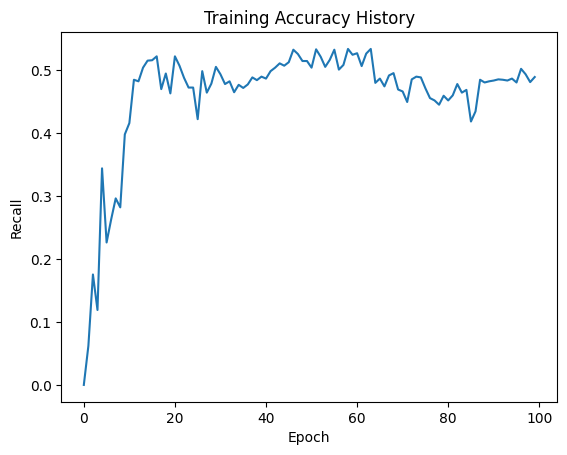

In [290]:
# restore model and return best accuracy
model.load_state_dict(best_weights)

torch.save(model, 'my_trained_model.pt') 

print("Best Recall: %.4f" % best_recall)
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training Accuracy History')
plt.show()


In [291]:
testing_data = data_encoded.drop('conversion_status_not_converted', axis=1)
y_true = testing_data['conversion_status_converted']

In [292]:
# Load the trained model
loaded_model = torch.load('my_trained_model.pt', map_location=device)


In [293]:
new_data_features = testing_data.drop('conversion_status_converted', axis=1)
new_data_features = new_data_features.values

new_data_tensor = torch.tensor(new_data_features, dtype=torch.float32, device=device)

In [294]:
loaded_model.eval()
with torch.no_grad():
    logits = model(new_data_tensor)
    probabilities = torch.sigmoid(logits)

In [295]:
# Convert predictions to numpy array
probabilities_numpy = probabilities.cpu().numpy()
predicted_labels = np.where(probabilities_numpy >= 0.5, 1, 0)


In [296]:
# Select 5 random data points
random_indices = np.random.choice(len(probabilities_numpy), size=5, replace=False)

# Print the predictions and actual values for the 5 random data points
for idx in random_indices:
    prob = probabilities_numpy[idx].item()
    pred_label = predicted_labels[idx].item()
    true_label = y_true[idx]  # Assuming y_new contains the actual labels
    print(f"Predicted Probability: {prob:.4f}, Predicted Label: {pred_label}, Actual Label: {true_label}")

Predicted Probability: 0.0464, Predicted Label: 0, Actual Label: 0
Predicted Probability: 0.0041, Predicted Label: 0, Actual Label: 0
Predicted Probability: 0.0000, Predicted Label: 0, Actual Label: 0
Predicted Probability: 0.0153, Predicted Label: 0, Actual Label: 0
Predicted Probability: 0.0197, Predicted Label: 0, Actual Label: 0


In [297]:
sorted_indices = np.argsort(probabilities_numpy, axis=0)[::-1].flatten()
top_indices = sorted_indices[:50]

print("Top 50 Data Points:")
for idx in top_indices:
    prob = probabilities_numpy[idx].item()
    pred_label = predicted_labels[idx].item()
    true_label = y_true[idx]  # Assuming y_new contains the actual labels
    print(f"Predicted Probability: {prob:.4f}, Predicted Label: {pred_label}, Actual Label: {true_label}")

Top 50 Data Points:
Predicted Probability: 0.9306, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.9170, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.9105, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.9081, Predicted Label: 1, Actual Label: 0
Predicted Probability: 0.9068, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.9052, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.8997, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.8964, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.8942, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.8938, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.8898, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.8886, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.8880, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.8855, Predicted Label: 1, Actual Label: 1
Predicted Probability: 0.8846, Predicted L

In [298]:
# Create a new DataFrame to store the results
results_df = pd.DataFrame({
    'Predicted_Probability': probabilities_numpy.flatten(),
    'Predicted_Label': predicted_labels.flatten(),
})

# Concatenate the original dataset with the results DataFrame
output_df = pd.concat([data, results_df], axis=1)

# Print the head of the output DataFrame
output_df

,occupation,age,education_level,marital_status,communication_channel,call_month,call_day,call_duration,call_frequency,previous_campaign_outcome,conversion_status,Predicted_Probability,Predicted_Label
0,administrative_staff,28,high_school,married,unidentified,September,9,1,1,successful,not_converted,3.196575e-09,0
1,administrative_staff,58,unidentified,married,unidentified,June,5,307,2,unidentified,not_converted,2.136702e-02,0
2,jobless,40,high_school,divorced,mobile,February,4,113,1,unidentified,not_converted,9.910520e-03,0
3,retired_worker,63,high_school,married,mobile,April,7,72,5,unidentified,not_converted,5.084544e-05,0
4,business_owner,43,college,married,landline,July,29,184,4,unidentified,not_converted,1.354291e-02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,administrative_staff,50,high_school,divorced,mobile,May,6,114,1,unsuccessful,not_converted,1.735582e-03,0
45207,independent_worker,49,college,married,unidentified,May,13,98,1,unidentified,not_converted,2.846873e-04,0
45208,executive,30,college,married,mobile,June,12,175,2,other_outcome,not_converted,3.681700e-01,0
45209,retired_worker,59,elementary_school,married,landline,July,15,41,5,unidentified,not_converted,1.610182e-07,0


In [299]:
# Writing output

output_df.to_csv('output.csv')